## Agent discussion panel

### Installing libraries

In [27]:
%%capture --no-stderr
%pip install -U dotenv langchain_core langgraph langgraph-supervisor langchain-tavily "langchain[openai]"

In [28]:
from dotenv import load_dotenv
load_dotenv()

True

In [29]:
from langchain_tavily import TavilySearch

web_search = TavilySearch(max_results=3)
web_search_results = web_search.invoke("Who is the president of Poland?")

print(web_search_results["results"][0]["content"])

Andrzej Sebastian Duda (born 16 May 1972) is a Polish lawyer and politician who served as the sixth president of Poland from 2015 to 2025.


### Helper functions

In [30]:
from langchain_core.messages import convert_to_messages


def pretty_print_message(message, indent=False):
    pretty_message = message.pretty_repr(html=True)
    if not indent:
        print(pretty_message)
        return

    indented = "\n".join("\t" + c for c in pretty_message.split("\n"))
    print(indented)


def pretty_print_messages(update, last_message=False):
    is_subgraph = False
    if isinstance(update, tuple):
        ns, update = update
        # skip parent graph updates in the printouts
        if len(ns) == 0:
            return

        graph_id = ns[-1].split(":")[0]
        print(f"Update from subgraph {graph_id}:")
        print("\n")
        is_subgraph = True

    for node_name, node_update in update.items():
        update_label = f"Update from node {node_name}:"
        if is_subgraph:
            update_label = "\t" + update_label

        print(update_label)
        print("\n")

        messages = convert_to_messages(node_update["messages"])
        if last_message:
            messages = messages[-1:]

        for m in messages:
            pretty_print_message(m, indent=is_subgraph)
        print("\n")

### Researcher agent

In [31]:
from langgraph.prebuilt import create_react_agent

research_agent = create_react_agent(
    model="openai:gpt-4.1",
    tools=[web_search],
    prompt=(
"You're the Researcher. You have access to fragments from the 'search engine' (RESEARCH).\n"
"Your goal is to provide factual, concise facts and data supporting the topic.\n"
"Refer to the fragments and do not invent. Write concisely and briefly."
"- After you finish your task, respond directly to the moderator\n"
"- Reply using only the results of your work, do not include the text."
    ),
    name="research_agent",
)

### Expert agent

In [32]:
expert_agent = create_react_agent(
    model="openai:gpt-4.1",
    tools=[],
    prompt=(
"You're the Expert. From the available facts, propose a practical solution/plan.\n"
"Include steps, requirements, and a minimal set of decisions. Write concretely."
"- After you finish your task, respond directly to the moderator\n"
"- Reply using only the results of your work, do not include the text."
    ),
    name="expert_agent",
)

### Agent critic

In [33]:
critic_agent = create_react_agent(
    model="openai:gpt-4.1",
    tools=[],
    prompt=(
"You're the Critic. Your role is to find gaps, risks, and ambiguities in the proposal.\n"
"Ask probing questions and point out missing elements. Be constructive."
"- After you finish your task, respond directly to the moderator\n"
"- Reply using only the results of your work, do not include the text."
    ),
    name="critic_agent",
)

In [34]:
from typing import Annotated
from langchain_core.tools import tool, InjectedToolCallId
from langgraph.prebuilt import InjectedState
from langgraph.graph import StateGraph, START, MessagesState
from langgraph.types import Command


def create_handoff_tool(*, agent_name: str, description: str | None = None):
    name = f"transfer_to_{agent_name}"
    description = description or f"Ask {agent_name} for help."

    @tool(name, description=description)
    def handoff_tool(
        state: Annotated[MessagesState, InjectedState],
        tool_call_id: Annotated[str, InjectedToolCallId],
    ) -> Command:
        tool_message = {
            "role": "tool",
            "content": f"Successfully transferred to {agent_name}",
            "name": name,
            "tool_call_id": tool_call_id,
        }
        return Command(
            goto=agent_name,
            update={**state, "messages": state["messages"] + [tool_message]},
            graph=Command.PARENT,
        )

    return handoff_tool

# Handoffs
assign_to_research_agent = create_handoff_tool(
    agent_name="research_agent",
    description="Assign task to a researcher agent.",
)

assign_to_expert_agent = create_handoff_tool(
    agent_name="expert_agent",
    description="Assign task to a expert agent.",
)

assign_to_critic_agent = create_handoff_tool(
    agent_name="critic_agent",
    description="Assign task to a critic agent.",
)

### Agent moderator

In [35]:
supervisor_agent = create_react_agent(
    model="openai:gpt-4.1",
    tools=[assign_to_research_agent, assign_to_expert_agent, assign_to_critic_agent],
    prompt=(
"You're the Moderator of a discussion in which 3 agents take part: Researcher, Critic and Expert. You decide whether we finish or continue.\n"
"If we continue, provide a SHORT next research query (research_query) for the Researcher, Critic or Expert. If we finish, summarize the discussion and present in a structured and clear way the answer to the question."
"- Researcher. Searches for information and provides facts that form the basis of further discussion\n"
"- Critic. Looks assertively at the conclusions so far and points out weak points and elements to change or improve\n"
"- Expert. Draws conclusions and makes theses. Tries to solve the task based on the information received from the Researcher and Critic\n"
"Assign the work to one agent at a time, do not call agents in parallel.\n"
"Do not take part in the work discussion yourself."
    ),
    name="supervisor",
)

### Budowa grafu

In [36]:
from langgraph.graph import END

# Define the multi-agent supervisor graph
supervisor = (
    StateGraph(MessagesState)
    # NOTE: `destinations` is only needed for visualization and doesn't affect runtime behavior
    .add_node(supervisor_agent, destinations=("research_agent", "expert_agent", "critic_agent", END))
    .add_node(research_agent)
    .add_node(expert_agent)
    .add_node(critic_agent)
    .add_edge(START, "supervisor")
    # always return back to the supervisor
    .add_edge("research_agent", "supervisor")
    .add_edge("expert_agent", "supervisor")
    .add_edge("critic_agent", "supervisor")
    .compile()
)

### Display the graph

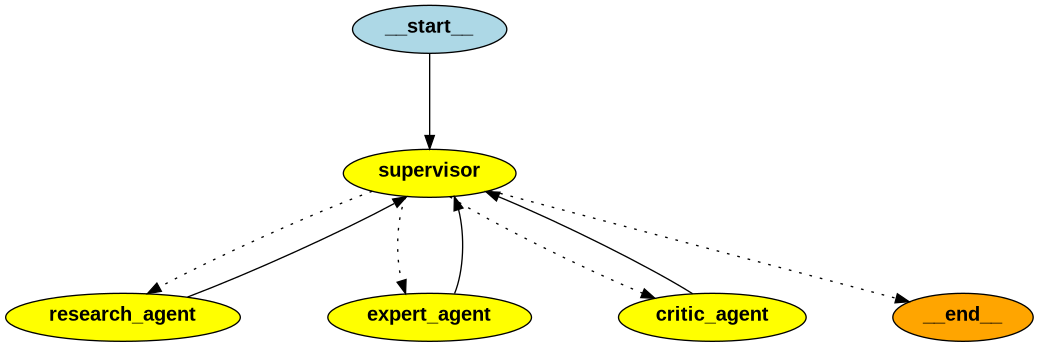

In [37]:
from IPython.display import display, Image

display(Image(supervisor.get_graph().draw_png()))

### Conduct a discussion on a given topic and display the answer

In [38]:
for chunk in supervisor.stream(
    {
        "messages": [
            {
                "role": "user",
                "content":" What field is best to study to have a well-paid and interesting profession in 10 years.",
            }
        ]
    },
    subgraphs=True,
):
    pretty_print_messages(chunk, last_message=True)

Update from subgraph supervisor:


	Update from node agent:


	================================== Ai Message ==================================
	Name: supervisor
	Tool Calls:
	  transfer_to_research_agent (call_IQ9yFVRsojCORDeOkO8ZLIDU)
	 Call ID: call_IQ9yFVRsojCORDeOkO8ZLIDU
	  Args:


Update from subgraph research_agent:


	Update from node agent:


	================================== Ai Message ==================================
	Name: research_agent
	Tool Calls:
	  tavily_search (call_OapqfUplIcEEN0gIi8icqXPP)
	 Call ID: call_OapqfUplIcEEN0gIi8icqXPP
	  Args:
	    query: best fields of study for high-paying and interesting professions in 10 years
	    search_depth: advanced


Update from subgraph research_agent:


	Update from node tools:


	================================= Tool Message =================================
	Name: tavily_search
	
	{"query": "best fields of study for high-paying and interesting professions in 10 years", "follow_up_questions": null, "answer": null, "im